<h1>NHL Stenden Detection Course</h1>
This notebook accompanies the NHL Stenden Detection Course lecture slides

![alternative text](notebook_detection_files/8_image.png)

<h2>Import Packages: Configuration</h2>
The followings imports are required to run the code. Click the run button to import the packages.

In [1]:
import numpy as np
import cv2
import torch
import glob as glob
import os

import torchvision
from torch.optim.lr_scheduler import StepLR
from torchvision.models.detection import FasterRCNN
from torchvision.models import ResNet18_Weights
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torch.utils.data import Dataset, DataLoader

import albumentations as A

import matplotlib.pyplot as plt

from xml.etree import ElementTree as et

from albumentations.pytorch import ToTensorV2

from scipy.optimize import linear_sum_assignment

<h2>Computing Hardware: Configuration</h2>
Neural Networks can be executed on different hardware devices. The following code block allows the user to indicate whether to run the Neural Network on the CPU or on the GPU.

In [2]:
# Either run the Neural Network on the CPU (run_cpu = True) or GPU (run_cpu = False)
run_cpu = False

if run_cpu:
    device = torch.device('cpu')
else:
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(42)

<h2>Data: Configuration</h2>
The following code downloads and loads the dataset. Transforms are used to resize and normalize the input images.

<h3>Exercise</h3>
1. <em> Adapt the batch size. What influence does it have on the performance of the model? </em>


In [3]:
# Make experiments reproducible
torch.manual_seed(42)
np.random.seed(42)

# Configuration (Feel free to experiment with these values)
batch_size = 6
resize_to_x = 300
resize_to_y = 400

# Name of the classes
classes = ['__background__', 'onrijp', 'rijp', 'overrijp']
num_classes = len(classes)

# Name of the output directory to store resulting images
output_dir = 'outputs'

<h2>Data: Standard Dataset</h2>
The following code denotes where the data is located.

In [4]:
# Location of the images and their annotations
train_dir = 'detectionBanana/train'
valid_dir = 'detectionBanana/valid'
test_dir = 'detectionBanana/test'
inference_dir = 'detectionBanana/inference'

<h2>Data: Dataset</h2>
The dataset consists of images and annotations. The __init__ function determines all file paths to the images. The __getitem__ function retrieves, on demand, a sample of the dataset together with its annotations. Note that the images are in jpg format and the annotations are xml files. The images and annotations should be located in the same folder and have identical names (apart from the extension).

In [5]:
class DetectionDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes

        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):

        # get name and path from a random image
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # preprocess image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        # load annotation that corresponds to image
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        image_width = image.shape[1]
        image_height = image.shape[0]

        # store all annotations in a list
        for member in root.findall('object'):

            labels.append(self.classes.index(member.find('name').text))
            b = member.find('bndbox')
            xmin = int(b.find('xmin').text)
            xmax = int(b.find('xmax').text)
            ymin = int(b.find('ymin').text)
            ymax = int(b.find('ymax').text)

            # resize the bounding boxes according to the resized images
            xmin = (xmin / image_width) * self.width
            xmax = (xmax / image_width) * self.width
            ymin = (ymin / image_height) * self.height
            ymax = (ymax / image_height) * self.height

            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        # apply the transforms on the data
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image_resized, target, image_path

    def __len__(self):
        return len(self.all_images)

<h2>Data: Transformations</h2>
To deal with limited data, data augmentations are applied on the dataset to increase the variability of the images. Augmentations including flipping, rotations and blurs are applied to training images. The validation images are treated as is, but are transformed to Torch tensors.

<h3>Exercise</h3>
1. <em> Add a Horizontal Flip to the list of transformations. What influence does it have on the performance of the model? </em><br>
2. <em> Implement several other data augmentations that are listed <a href="https://pytorch.org/vision/stable/transforms.html">here</a>. Think about which augmentations could be useful. What influence does it have on the performance of the model? </em>

In [6]:
# Only apply data augmentation when training
train_transforms = A.Compose([
        A.ColorJitter(brightness=0, contrast=0, saturation=0.2, hue=0.01),
        A.MultiplicativeNoise(multiplier=(0.98, 1.02), elementwise=True, p=0.9),
        A.RandomBrightnessContrast(p=0.5),
        #A.HorizontalFlip(p=0.5),
        ToTensorV2(p=1.0),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Convert validation data to tensor format
test_transforms = A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

<h2>Data: Dataset Division</h2>
The following code downloads and loads the dataset.  Three different loaders are used for the training, validation and testing images. This ensures that the images do not overlap across the splits.

In [7]:
#https://public.roboflow.com/object-detection/chess-full
train_dataset = DetectionDataset(train_dir, resize_to_x, resize_to_y, classes, train_transforms)
valid_dataset = DetectionDataset(valid_dir, resize_to_x, resize_to_y, classes, train_transforms)
test_dataset = DetectionDataset(test_dir, resize_to_x, resize_to_y, classes, test_transforms)

train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn= lambda batch: tuple(zip(*batch)))

valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: tuple(zip(*batch)))

test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
        collate_fn=lambda batch: tuple(zip(*batch)))

<h2>Data: Data Science Perspective (Qualitative)</h2>
The following code block is responsible for visualizing an image after being preprocessed by the transformations. Feel free to run this block multiple times to display different images.

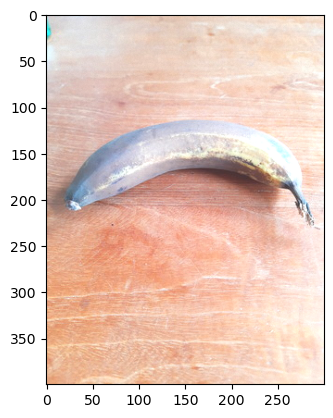

overrijp


In [8]:
# Normalize the image to be in the range [0, 1] and display one batch
def imshow(img):
    plt.imshow(np.transpose((img.numpy() * 255).astype(np.uint8), (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, annotations, _ = next(dataiter)

# Get a single image / annotation pair
image = images[0]
labels = annotations[0]['labels']

# show images
imshow(image)

for label in labels:
    print(classes[label])

<h2>Data: Data Science Perspective (Quantitative)</h2>
The following code block is responsible for displaying some statistics of the training dataset.

In [9]:
print(f"Number of train samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")
print(f"Number of test samples: {len(test_dataset)}\n")

train_labels = {}

dataiter = iter(train_loader)
#dataiter = iter(valid_loader)
images, labels, _= next(dataiter)

channel, height, width = images[0].shape

print("Images have %d channel(s) with height %d and width %d" % (channel, height, width))
for i, (inputs, labels, _) in enumerate(train_loader, 0): #
    # get the inputs; data is a list of [inputs, labels]
    for label in labels:
        for l in label['labels']:
            if l.item() in train_labels:
                train_labels[l.item()] += 1
            else:
                train_labels[l.item()] = 1

print("Number of classes: " + str(len(train_labels.keys())))
print("Number of instances per class:")

for key in sorted(train_labels):
    print("%s: %s" % (classes[key], train_labels[key]))

print("Accuracy random guessing on train set: " + str(float(max(train_labels.values()) / int(sum(train_labels.values())))))

Number of train samples: 103
Number of validation samples: 17
Number of test samples: 25

Images have 3 channel(s) with height 400 and width 300
Number of classes: 3
Number of instances per class:
onrijp: 27
rijp: 47
overrijp: 29
Accuracy random guessing on train set: 0.4563106796116505


<h2>Region Proposal: Selective Search</h2>
The following code generated a set of bounding boxes using selective search.

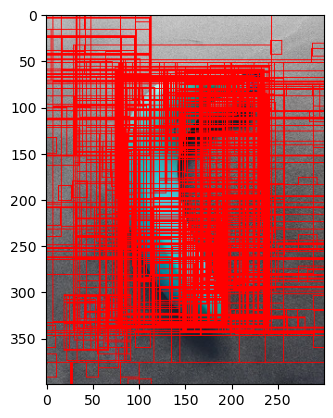

Amount of rectangles: 1162


In [10]:
# load the input image
image = cv2.imread('detectionBanana/train/IMG_20230308_163123474.jpg')
image = cv2.resize(image, (resize_to_x, resize_to_y))

# initialize OpenCV's selective search implementation and set the input image
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchQuality()
rects = ss.process()

output = image.copy()

color = [255,0,0]

# loop over the current subset of region proposals
for (x, y, w, h) in rects[0:len(rects)]:
    # draw the region proposal bounding box on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)

plt.imshow(image)
plt.show()
print(f"Amount of rectangles: {len(rects)}")

<h2>Region-Based CNN: Faster R-CNN</h2>
The following function creates the Faster-RCNN object detection model. First a backbone model is selected (ResNet18). Second, anchors are generated with default sizes and aspect ratios which uses apriori bounding box knowledge about the classes.  Third, the multiscale region of interest functionality is implemented. Finally, the model is constructed using the above described components.

<h3>Exercise</h3>
1. <em> Change the learning rate. Try to experiment with values between 0.1 and 0.0001. What effect does it have on the training behaviour? Is the model performing better or worse? </em> <br>
2. <em> Change the detection threshold. Choose both smaller and larger values. What happens if you look at the qualitative test results? </em>

In [11]:
learning_rate = 0.0001
num_epochs = 60
detection_threshold = 0.6

def create_model(num_classes):

    backbone = resnet_fpn_backbone('resnet18', weights=ResNet18_Weights.DEFAULT, trainable_layers=2)

    anchor_generator = AnchorGenerator(
        sizes=((16,), (32,), (64,), (128,), (256,)),
        aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)]))

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'],
                                                    output_size=7, sampling_ratio=2)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone, num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)
    return model

model = create_model(num_classes=num_classes).to(device)

C:\Users\bryan\.conda\envs\tf-gpu\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


<h2>Training a Faster R-CNN Model: Loss Function and Optimizer</h2>
A loss function is used to compute the discrepancy between the prediction of the network and the desired output. This discrepancy is then minimized by executing an optimization algorithm. The following code block defines the loss function and instantiates the optimizer.

<h3>Exercise</h3>
1. <em> Change the SGD optimizer to Adam. What difference does it make on the training process and overall performance of the model? </em> <br>
2. <em> Increase the step size in the StepLR function. What happens to the training procedure?

In [12]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

<h2>Training a Faster R-CNN Model: Forward and Backward</h2>
The Neural Network is ready to be trained. The following code block loops once over all training inputs (one epoch) and validates the performance.

In [13]:
torch.cuda.empty_cache()

train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

best_valid_loss = float('inf')

current_lr = learning_rate

# Run the training loop several times
for epoch in range(num_epochs):

    train_loss_hist = 0
    val_loss_hist = 0

    train_itr = 0
    val_itr = 0

    # Train the model
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        images, targets, _ = data

        images = list(image.to(device=device) for image in images)
        targets = [{k: v.to(device=device) for k, v in t.items()} for t in targets]

        # Obtain the loss from the model
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist = train_loss_hist + loss_value

        losses.backward()
        optimizer.step()

        train_itr += 1

        del images
        del targets

    # Validate the model
    for i, data in enumerate(valid_loader):
        images, targets, _ = data

        images = list(image.to(device=device) for image in images)
        targets = [{k: v.to(device=device) for k, v in t.items()} for t in targets]

        # Obtain the loss from the model
        with torch.no_grad():
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        val_loss_hist = val_loss_hist + loss_value

        val_itr += 1

        del images
        del targets

    print(f"Training loss after {str(epoch + 1)} epochs is: {str(train_loss_hist / train_itr)}")
    print(f"Validation loss after {str(epoch + 1)} epochs is: {str(val_loss_hist / val_itr)}")

    if val_loss_hist < best_valid_loss:
        best_valid_loss = val_loss_hist
        print("Found a lower validation loss, storing model.\n")
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'best_model.pth')

    scheduler.step()
    print(f"Current learning rate: {scheduler._last_lr[0]}")

Training loss after 1 epochs is: 0.5542416017916467
Validation loss after 1 epochs is: 0.25980904698371887
Found a lower validation loss, storing model.

Current learning rate: 0.0001
Training loss after 2 epochs is: 0.22733979465232956
Validation loss after 2 epochs is: 0.21841139594713846
Found a lower validation loss, storing model.

Current learning rate: 0.0001
Training loss after 3 epochs is: 0.21116717242532307
Validation loss after 3 epochs is: 0.20662501454353333
Found a lower validation loss, storing model.

Current learning rate: 0.0001
Training loss after 4 epochs is: 0.2041039831108517
Validation loss after 4 epochs is: 0.18595260878403982
Found a lower validation loss, storing model.

Current learning rate: 0.0001
Training loss after 5 epochs is: 0.1925412296420998
Validation loss after 5 epochs is: 0.17786570886770883
Found a lower validation loss, storing model.

Current learning rate: 0.0001
Training loss after 6 epochs is: 0.16639575444989735
Validation loss after 6 e

Current learning rate: 1.0000000000000005e-09
Training loss after 52 epochs is: 0.05902567029827171
Validation loss after 52 epochs is: 0.0969525674978892
Current learning rate: 1.0000000000000005e-09
Training loss after 53 epochs is: 0.05887792921728558
Validation loss after 53 epochs is: 0.09287687639395396
Current learning rate: 1.0000000000000005e-09
Training loss after 54 epochs is: 0.058969154953956604
Validation loss after 54 epochs is: 0.09495260566473007
Current learning rate: 1.0000000000000005e-09
Training loss after 55 epochs is: 0.06053918144769139
Validation loss after 55 epochs is: 0.09519862880309422
Current learning rate: 1.0000000000000005e-09
Training loss after 56 epochs is: 0.05909657871557607
Validation loss after 56 epochs is: 0.08756252874930699
Current learning rate: 1.0000000000000005e-09
Training loss after 57 epochs is: 0.059478378751211695
Validation loss after 57 epochs is: 0.09456206361452739
Current learning rate: 1.0000000000000005e-09
Training loss aft

<h2>Testing: IoU, TP, FP, FN, Precision, Recall, F1-Score</h2>
The following code block defines the metrics for assessing the performance on the object detection model.

In [14]:
# Computes the area of overlap between each ground-truth and predicted box
def calc_box_iou(boxes1, boxes2) -> np.ndarray:

    x11, y11, x12, y12 = np.split(boxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(boxes2, 4, axis=1)
    x_a = np.maximum(x11, np.transpose(x21))
    y_a = np.maximum(y11, np.transpose(y21))
    x_b = np.minimum(x12, np.transpose(x22))
    y_b = np.minimum(y12, np.transpose(y22))
    inter_area = np.maximum((x_b - x_a + 1), 0) * np.maximum((y_b - y_a + 1), 0)
    box_a_area = (x12 - x11 + 1) * (y12 - y11 + 1)
    box_b_area = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = inter_area / (box_a_area + np.transpose(box_b_area) - inter_area)

    return iou

# Computes the true positives, false positives and false negatives
def calc_tp_fp_fn(gt_boxes, pred_boxes, iou_scores, iou_thr) -> tuple[int, int, int]:

    row_ind, col_ind = linear_sum_assignment(1 - iou_scores)

    len_tp = len(iou_scores[row_ind, col_ind] > iou_thr)

    tp = len_tp
    fp = len(pred_boxes) - len_tp
    fn = len(gt_boxes) - len_tp

    return tp, fp, fn

# Computes the precision and recall
def calc_precision_recall(tp, fp, fn) -> tuple[int, int]:

    tp_fp = tp + fp
    precision = tp/tp_fp if tp_fp else 0

    tp_fn = tp + fn
    recall = tp/tp_fn if tp_fn else 0

    return precision, recall

# Computes the f1 score
def calc_f1_score(precision, recall) -> float:

    numerator = 2 * precision * recall
    denominator = precision + recall

    return numerator / denominator if denominator else 0

<h2>Testing: Qualitative Results on Full Resolution Images</h2>
The following code block performs inference on images. The resulting images and the predicted boxes are stored on disk for display.

In [15]:
torch.cuda.empty_cache()

colors = np.random.uniform(0, 255, size=(len(classes), 3))

# load model and set it to evaluate mode
model = create_model(num_classes=num_classes)
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

target_dict = {}
pred_dict = {}

total_tp = dict.fromkeys(range(num_classes), 0)
total_fp = dict.fromkeys(range(num_classes), 0)
total_fn = dict.fromkeys(range(num_classes), 0)

list_values = []
for i, data in enumerate(test_loader):

    images, targets, image_path = data

    images = list(image.to(device=device) for image in images)
    targets = [{k: v.to(device=device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        outputs = model(images)

    # if there are found objects
    if len(outputs[0]['boxes']) > 0:

        pred_boxes = outputs[0]['boxes']
        pred_scores = outputs[0]['scores']
        pred_labels = outputs[0]['labels']

        target_boxes = targets[0]['boxes']
        target_labels = targets[0]['labels']
        #pred_score is confidence
        nms_indices = torchvision.ops.nms(pred_boxes, pred_scores, 0.3)

        pred_boxes = pred_boxes[nms_indices].cpu().numpy()
        pred_scores = pred_scores[nms_indices].cpu().numpy()
        pred_labels = pred_labels[nms_indices].cpu().numpy()

        target_boxes = target_boxes.cpu().numpy()
        target_labels = target_labels.cpu().numpy()

        # only consider boxes with a score larger than the detection threshold
        pred_boxes = pred_boxes[pred_scores >= detection_threshold]
        pred_labels = pred_labels[pred_scores >= detection_threshold]

        # get class names of predictions
        pred_classes = [classes[i] for i in pred_labels]

        # draw the bounding boxes together with their names on a copy of the image
        image = cv2.imread(image_path[0])

        h, w, c = image.shape

        scale_w = w / resize_to_x
        scale_h = h / resize_to_y

        orig_image = image.copy()

        for j, box in enumerate(pred_boxes):
            class_name = pred_classes[j]
            color = colors[classes.index(class_name)]
            cv2.rectangle(orig_image,
                        (int(box[0] * scale_w), int(box[1] * scale_h)),
                        (int(box[2] * scale_w), int(box[3] * scale_h)),
                        color, 2)
            cv2.putText(orig_image, class_name,
                        (int(box[0] * scale_w), int(box[1] * scale_h -5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color,
                        2)

        for class_id in range(len(classes)):

            pred_boxes_class = pred_boxes[pred_labels == class_id]
            target_boxes_class = target_boxes[target_labels == class_id]

            if len(pred_boxes_class) == 0 or len(target_boxes_class) == 0:
                tp, fp, fn = 0, len(pred_boxes_class), len(target_boxes_class)
            else:
                iou_scores = calc_box_iou(pred_boxes_class, target_boxes_class)
                tp, fp, fn = calc_tp_fp_fn(gt_boxes=target_boxes_class, pred_boxes=pred_boxes_class, iou_scores=iou_scores, iou_thr=0.3)

            total_tp[class_id] += tp
            total_fp[class_id] += fp
            total_fn[class_id] += fn

    cv2.imwrite(f"{i}_image.png", orig_image, [int(cv2.IMWRITE_PNG_COMPRESSION),8])
    print(f"Processed image {i+1}/{len(test_loader)}")

Processed image 1/25
Processed image 2/25
Processed image 3/25
Processed image 4/25
Processed image 5/25
Processed image 6/25
Processed image 7/25
Processed image 8/25
Processed image 9/25
Processed image 10/25
Processed image 11/25
Processed image 12/25
Processed image 13/25
Processed image 14/25
Processed image 15/25
Processed image 16/25
Processed image 17/25
Processed image 18/25
Processed image 19/25
Processed image 20/25
Processed image 21/25
Processed image 22/25
Processed image 23/25
Processed image 24/25
Processed image 25/25


In [16]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

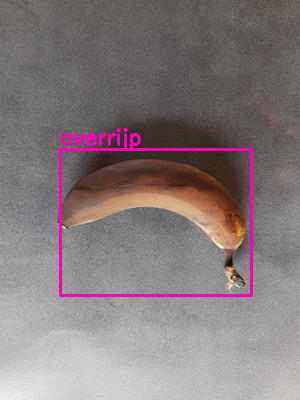

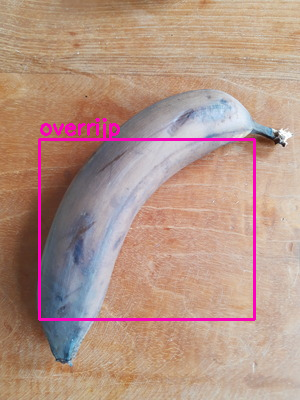

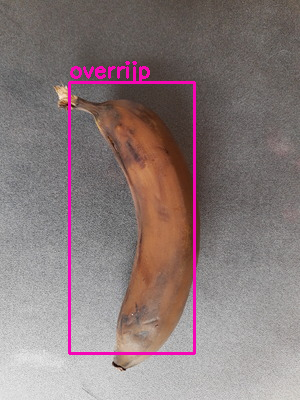

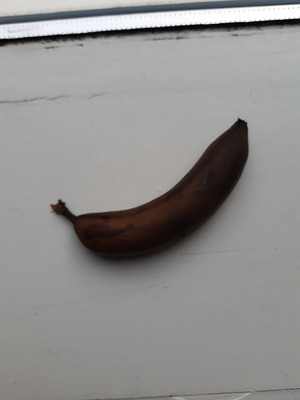

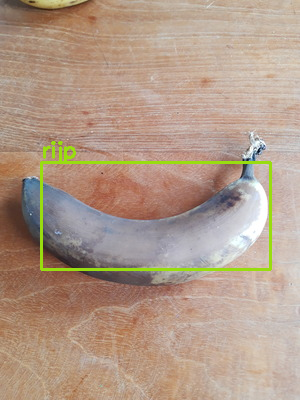

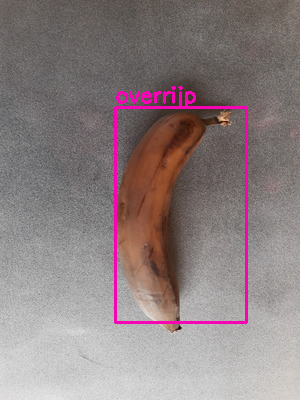

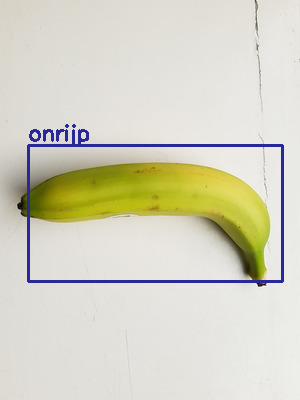

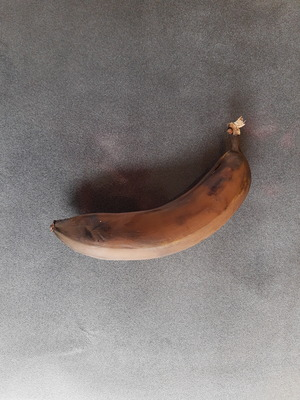

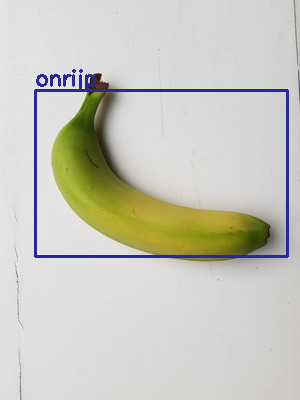

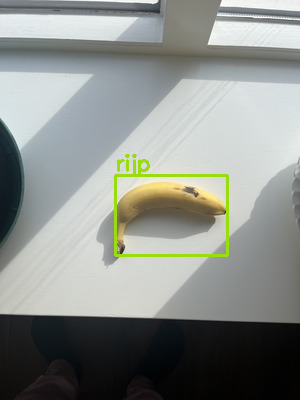

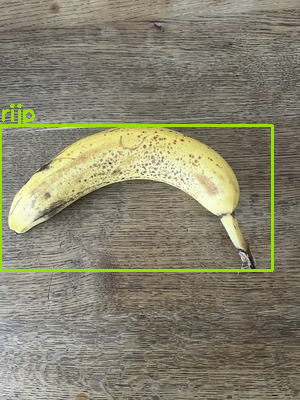

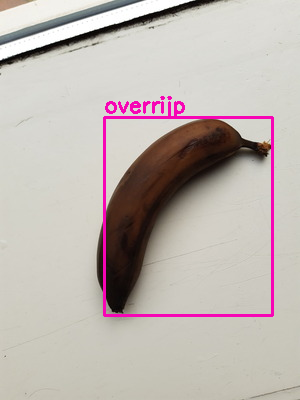

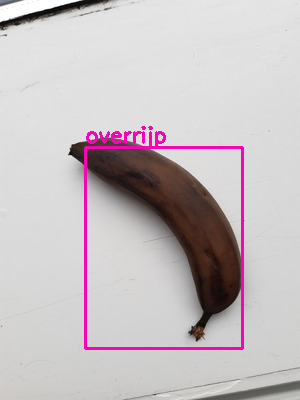

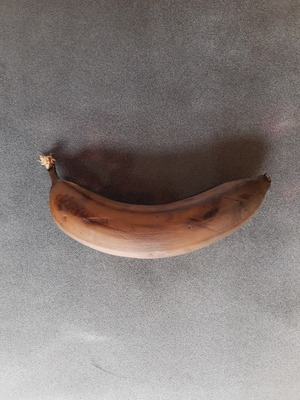

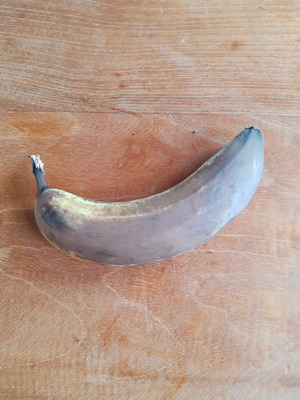

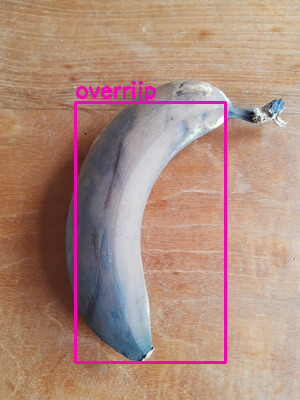

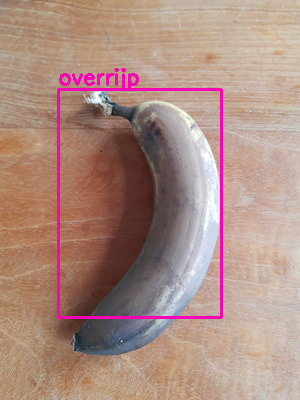

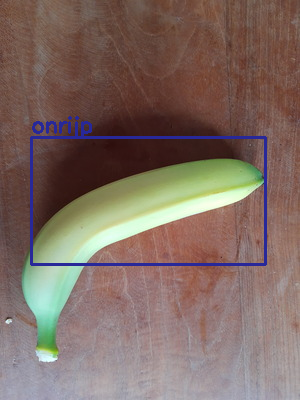

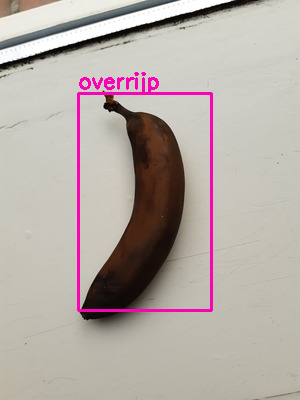

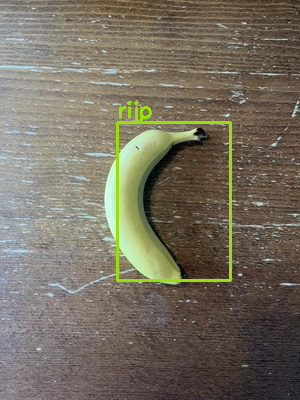

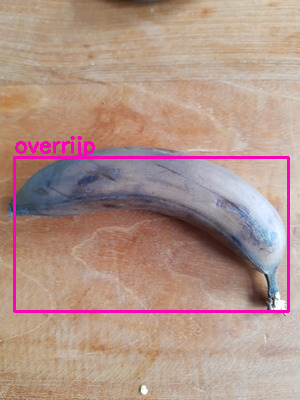

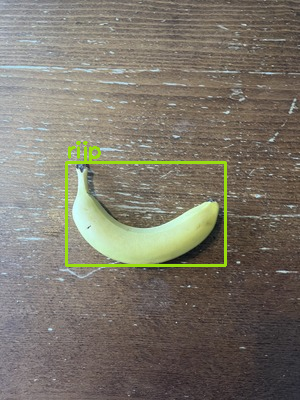

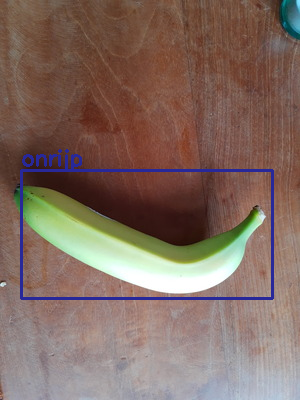

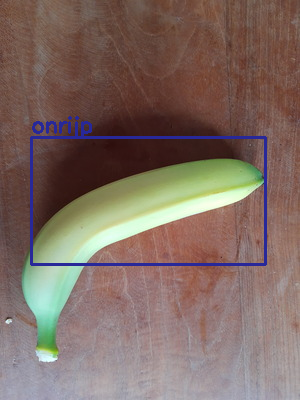

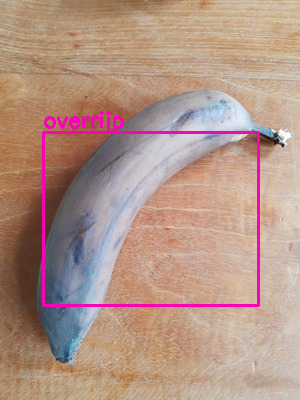

In [17]:
from IPython.display import Image, display

images = [f"{idx}_image.png" for idx in range(len(test_loader))]

for image in images:
    display(Image(filename=image))

<h2>Testing: Quantitative Results on Network Predictions</h2>
The following code block determines the network performance on the testing set. The true positives, false positives and false negatives are displayed per class. Additionally, the overall precision, recall and f1-score are displayed.

<h3> Exercise </h3>
1. <em> What can you conclude from the computed metrics? Is a particular chess piece much harder to detect than others? Do you know any reason for this? </em>

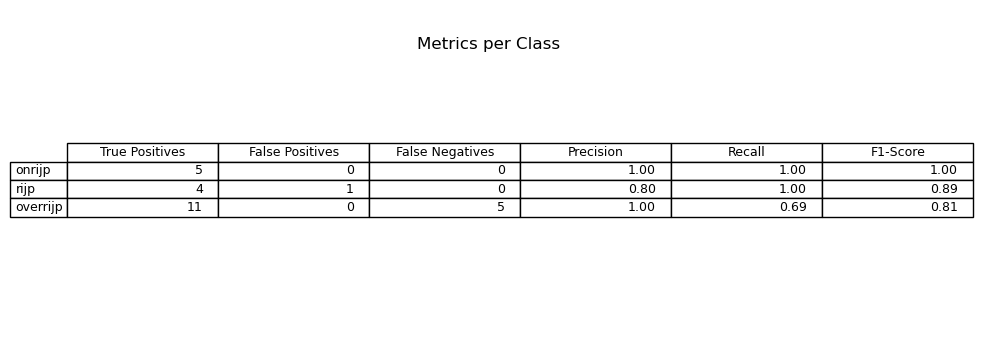

Overall Precision:  0.95
Overall Recall:  0.80
Overall F1:  0.87


In [18]:
# Compute statistics per class
for class_id in range(1, num_classes):
    tp = total_tp[class_id]
    fp = total_fp[class_id]
    fn = total_fn[class_id]

    precision, recall = calc_precision_recall(tp=tp, fp=fp, fn=fn)
    f1 = calc_f1_score(precision, recall)

    list_values.append([tp, fp, fn, f'{precision:.2f}', f'{recall:.2f}', f'{f1:.2f}'])

# Create table with statistics per class
fig, ax = plt.subplots(figsize=(10, 4))

fig.suptitle("Metrics per Class", y = 0.82)
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=list_values, rowLabels=classes[1:], colLabels=["True Positives", "False Positives", "False Negatives", "Precision", "Recall", "F1-Score"], loc='center')

fig.tight_layout()

plt.show()

# Compute overall statistics
precision, recall = calc_precision_recall(tp=sum(total_tp.values()), fp=sum(total_fp.values()), fn=sum(total_fn.values()))
f1 = calc_f1_score(precision, recall)

print("Overall Precision: ", f'{precision:.2f}')
print("Overall Recall: ", f'{recall:.2f}')
print("Overall F1: ", f'{f1:.2f}')

<h2>Inference: Qualitative Results on Images without Annotations</h2>
The following codeblock takes a test directory and directly loads in the images.

In [19]:
ripe_counter = 0
overripe_counter = 0
underripe_counter = 0


torch.cuda.empty_cache()

colors = np.random.uniform(0, 255, size=(len(classes), 3))

# load model and set it to evaluate mode
model = create_model(num_classes=num_classes)
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

# determine the file paths to the test images
test_images = glob.glob(f"{test_dir}/*.jpg")

num_test_images = len(test_images)

for i in range(len(test_images)):

    # load in per image
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])

    h, w, c = image.shape

    scale_w = w / resize_to_x
    scale_h = h / resize_to_y

    orig_image = image.copy()

    image = cv2.resize(image, (resize_to_x, resize_to_y))

    # preprocess the images
    image = image.astype(np.float32)
    image /= 255.0
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    image = torch.tensor(image, dtype=torch.float).cuda()
    image = torch.unsqueeze(image, 0)

    # perform a prediction on the processed image
    with torch.no_grad():
        outputs = model(image.to(device))

    # process the detections on the cpu
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

    # if there are found objects
    if len(outputs[0]['boxes']) > 0:

        boxes = outputs[0]['boxes']
        scores = outputs[0]['scores']
        nms_indices = torchvision.ops.nms(boxes, scores, 0.5)

        boxes = boxes[nms_indices].data.numpy()
        confidences = scores[nms_indices].data.numpy()

        # only consider boxes with a score larger than the detection threshold
        boxes = boxes[confidences >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()

        # get class names of predictions
        pred_classes = [classes[i] for i in outputs[0]['labels'].cpu().numpy()]

        # draw the bounding boxes together with their names on a copy of the image
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            if class_name == "rijp":
                ripe_counter += 1
            elif class_name == "overrijp":
                overripe_counter += 1
            elif class_name == "onrijp":
                underripe_counter += 1
            color = colors[classes.index(class_name)]
            cv2.rectangle(orig_image,
                        (int(box[0] * scale_w), int(box[1] * scale_h)),
                        (int(box[2] * scale_w), int(box[3] * scale_h)),
                        color, 2)
            cv2.putText(orig_image, class_name,
                        (int(box[0] * scale_w), int(box[1] * scale_h -5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color,
                        2)
    cv2.imwrite(f"{i}_image.png", orig_image, [int(cv2.IMWRITE_PNG_COMPRESSION),8])
    print(f"Processed image {i+1}/{len(test_images)}")
    print(f"huidige banaan was: {class_name} ")
    print(f"onrijpe count: {underripe_counter}, overrijpe count: {overripe_counter}, rijpe count:{ripe_counter} ")
print(f"rijp ratio: {ripe_counter / (ripe_counter + underripe_counter + overripe_counter) * 100} %")
print(f"overrijp ratio: {overripe_counter / (ripe_counter + underripe_counter + overripe_counter) * 100} %")
print(f"onderrijp ratio: {underripe_counter / (ripe_counter + underripe_counter + overripe_counter) * 100} %")
print(f"verlies op inkoop: {underripe_counter * 0.03} eur op {ripe_counter + underripe_counter + overripe_counter} bananen")

Processed image 1/25
huidige banaan was: rijp 
onrijpe count: 0, overrijpe count: 0, rijpe count:1 
Processed image 2/25
huidige banaan was: rijp 
onrijpe count: 0, overrijpe count: 0, rijpe count:2 
Processed image 3/25
huidige banaan was: rijp 
onrijpe count: 0, overrijpe count: 0, rijpe count:3 
Processed image 4/25
huidige banaan was: rijp 
onrijpe count: 0, overrijpe count: 0, rijpe count:4 
Processed image 5/25
huidige banaan was: rijp 
onrijpe count: 0, overrijpe count: 0, rijpe count:5 
Processed image 6/25
huidige banaan was: overrijp 
onrijpe count: 0, overrijpe count: 1, rijpe count:5 
Processed image 7/25
huidige banaan was: rijp 
onrijpe count: 0, overrijpe count: 1, rijpe count:6 
Processed image 8/25
huidige banaan was: overrijp 
onrijpe count: 0, overrijpe count: 2, rijpe count:6 
Processed image 9/25
huidige banaan was: overrijp 
onrijpe count: 0, overrijpe count: 3, rijpe count:6 
Processed image 10/25
huidige banaan was: overrijp 
onrijpe count: 0, overrijpe count: 5